In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.regularizers import L1L2

import fun1
import fun2
from sklearn.model_selection import train_test_split
import noniid2

2023-03-31 11:51:02.234468: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 11:51:02.237807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 11:51:02.237818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def create_keras_model(tr_x):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential()
    model.add(Dense(20, activation = 'relu', 
                    input_shape=(tr_x.shape[1],), 
                    kernel_initializer=initializer))
    model.add(Dense(15, activation = 'relu', 
                    kernel_initializer=initializer))
    model.add(Dense(10, activation = 'relu', 
                    kernel_initializer=initializer))
    model.add(Dense(1, activation = 'sigmoid', 
                    kernel_initializer=initializer))
    return model   

In [3]:
def create_keras_model2(tr_x, regu_para):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential()
    model.add(Dense(20, activation = 'relu', 
                    input_shape=(tr_x.shape[1],), 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    model.add(Dense(15, activation = 'relu', 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    model.add(Dense(10, activation = 'relu', 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    model.add(Dense(1, activation = 'sigmoid', 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    return model   

In [4]:
def create_and_compile_model(tr_x, merge_w, lr, regu_para):
    
    model_m4 = create_keras_model2(tr_x, regu_para)
    model_m4.set_weights(merge_w)
    model_m4.compile(optimizer = optimizers.RMSprop(lr=lr, 
                                                    centered=True), 
                     loss = 'binary_crossentropy', 
                     metrics = ['accuracy'])
    return model_m4

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
def model_train_round(
    model_m3, m3_tr_x, m3_tr_y, epo_num, bs):
    
    callback = EarlyStopping(monitor='loss', 
                             patience=epo_num, 
                             restore_best_weights=True)

    m3_h = model_m3.fit(m3_tr_x, m3_tr_y, 
                        batch_size = bs, epochs = epo_num, 
                        verbose = 0, callbacks=[callback])  
    return model_m3

In [6]:
import matplotlib.pyplot as plt
def plot_performance_curve(r_tr_acc_ls, 
                           total_rounds, tr_or_ts_acc):
    r_tr_acc_trans = np.array(r_tr_acc_ls).T
    rounds = range(1, total_rounds + 1)

    for line in r_tr_acc_trans:
        plt.plot(rounds, line, 'ko-')

    plt.xticks(np.arange(1, total_rounds+1, 1))    
    plt.xlabel('Round')
    plt.ylabel('{} Accuracy'.format(tr_or_ts_acc))
    plt.show()

In [7]:
def get_weight_ls(c0_tr_y_ls):
    cluster_size = []
    for i in c0_tr_y_ls:
        cluster_size.append(len(i))    
    total_size = sum(cluster_size)
    cluster_weight_ls = [x/total_size for x in cluster_size]
    return cluster_weight_ls

In [8]:
def non_iid_factors(m3tr, m4tr, etr):
    
    sig_p = 0.05
    df_cols = m3tr.columns.tolist()
    cat_com_elems = df_cols[4:6] 
    cont_com_elems = df_cols[6:]     

    cat_f_value_ls = []
    for cat_f in cat_com_elems:
        cat_f_value = m3tr[cat_f].unique()
        cat_f_value_ls.append(cat_f_value)    
    
    m3m4_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, m4tr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    m3e_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, etr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    m4e_noniid = noniid2.non_iid_degree(
        sig_p, m4tr, etr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    
    m3_noniid_sum = sum([m3m4_noniid, m3e_noniid])
    m4_noniid_sum = sum([m3m4_noniid, m4e_noniid])
    e_noniid_sum = sum([m4e_noniid, m3e_noniid])
    
    total_noniid_sum = m3_noniid_sum+m4_noniid_sum+e_noniid_sum
    m3_factor = m3_noniid_sum/total_noniid_sum
    m4_factor = m4_noniid_sum/total_noniid_sum
    e_factor = e_noniid_sum/total_noniid_sum
    
    return m3_factor, m4_factor, e_factor

In [9]:
def non_iid_factors2(m3tr, m4tr, etr):
    
    sig_p = 0.05
    df_cols = m3tr.columns.tolist()
    cat_com_elems = df_cols[4:6] 
    cont_com_elems = df_cols[6:]     

    cat_f_value_ls = []
    for cat_f in cat_com_elems:
        cat_f_value = m3tr[cat_f].unique()
        cat_f_value_ls.append(cat_f_value)    
    
    m3m4_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, m4tr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    m3e_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, etr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
#     m4e_noniid = noniid2.non_iid_degree(
#         sig_p, m4tr, etr, 
#         cont_com_elems, cat_com_elems, cat_f_value_ls)
    m3m3_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, m3tr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls) 
    
    total_noniid_sum = m3m3_noniid+m3m4_noniid+m3e_noniid
    m3_factor = m3m3_noniid/total_noniid_sum
    m4_factor = m3m4_noniid/total_noniid_sum
    e_factor = m3e_noniid/total_noniid_sum
    
    return m3_factor, m4_factor, e_factor

In [10]:
def data_preprocessing(m3tr, m3ts, m4tr, m4ts, 
                       etr, ets):
    df_cols = m3tr.columns.tolist()
    cat_f_ls = df_cols[4:6]
    for i in cat_f_ls:
        m3tr[i] = m3tr[i].astype('category').cat.codes
        m3ts[i] = m3ts[i].astype('category').cat.codes
        m4tr[i] = m4tr[i].astype('category').cat.codes 
        m4ts[i] = m4ts[i].astype('category').cat.codes
        etr[i] = etr[i].astype('category').cat.codes
        ets[i] = ets[i].astype('category').cat.codes 
    return m3tr, m3ts, m4tr, m4ts, etr, ets

In [11]:
validation_round = 5
epo_num = 10
bs = 50
total_rounds = 10
lr = 3e-3
lr_decay_rate = 0.95
model_types = 'nn'

In [12]:
path = '/home/ai03/_kunyi/pro_shae/datasets/aki_prediction_m4_m3_eicu/'
input_folder = '6tw_6ts_6pre_5 folds_v1_tr and ts/'
input_dir = path+input_folder

< Validation 1 >


2023-03-31 11:51:06.575093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 11:51:06.575165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-31 11:51:06.575207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-31 11:51:06.576827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-31 11:51:06.576877: W tensorflow/stream_executor/platform/default/dso_loader

Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.15, m4 tr: 72.16, e tr: 84.98
m3 ts: 75.48, m4 ts: 71.8, e ts: 83.37
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.8, m4 tr: 74.26, e tr: 85.91
m3 ts: 79.72, m4 ts: 74.03, e ts: 85.52
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 77.81, m4 tr: 75.44, e tr: 84.22
m3 ts: 80.63, m4 ts: 75.29, e ts: 86.09
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.16, m4 tr: 75.07, e tr: 84.63
m3 ts: 80.71, m4 ts: 75.0, e ts: 86.02
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 73.32, m4 tr: 76.66, e tr: 80.92
m3 ts: 81.59, m4 ts: 76.29, e ts: 86.47
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 75.78, m4 tr: 75.94, e tr: 82.95
m3 ts: 81.13, m4 ts: 75.69, e ts: 86.32
Round 7
995/995 [==============================] - 1s 1ms/step
m3 tr: 77.45, m4 tr: 75.52, e tr: 84.06
m3 ts: 80.89, m4 ts: 75.42, e ts: 86.22
Ro

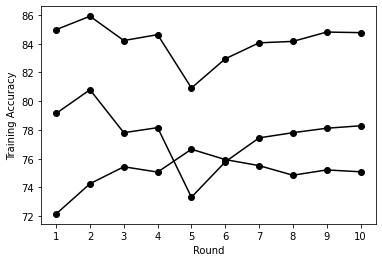

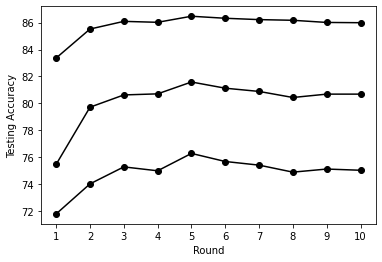

995/995 [==============================] - 2s 2ms/step
Validation 1 - Round m3 ts: 80.69, m4 ts: 75.04, e ts: 85.99
< Validation 2 >
Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.48, m4 tr: 72.04, e tr: 85.27
m3 ts: 77.12, m4 ts: 70.52, e ts: 85.06
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.76, m4 tr: 75.39, e tr: 84.71
m3 ts: 81.5, m4 ts: 72.46, e ts: 86.0
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.31, m4 tr: 75.86, e tr: 83.71
m3 ts: 81.65, m4 ts: 72.74, e ts: 85.18
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 77.28, m4 tr: 75.72, e tr: 82.37
m3 ts: 81.8, m4 ts: 72.66, e ts: 84.89
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.75, m4 tr: 75.28, e tr: 84.02
m3 ts: 81.47, m4 ts: 72.42, e ts: 85.6
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.56, m4 tr: 75.69, e tr: 83.43
m3 ts: 81.6, m4 ts: 72.65, e ts: 85.5
Round 7
995/995

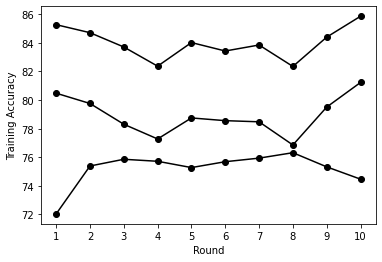

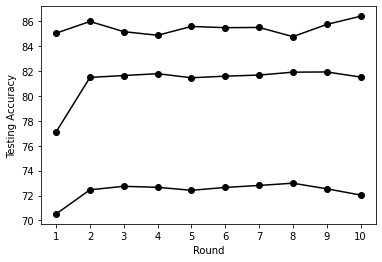

995/995 [==============================] - 2s 2ms/step
Validation 2 - Round m3 ts: 81.53, m4 ts: 72.04, e ts: 86.42
< Validation 3 >
Round 1
995/995 [==============================] - 1s 1ms/step
m3 tr: 81.89, m4 tr: 73.53, e tr: 86.15
m3 ts: 73.16, m4 ts: 72.38, e ts: 85.76
Round 2
995/995 [==============================] - 1s 1ms/step
m3 tr: 77.13, m4 tr: 76.12, e tr: 83.42
m3 ts: 76.07, m4 ts: 74.06, e ts: 84.92
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 76.68, m4 tr: 76.19, e tr: 83.09
m3 ts: 76.15, m4 ts: 74.15, e ts: 84.72
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.35, m4 tr: 74.57, e tr: 86.29
m3 ts: 74.16, m4 ts: 73.12, e ts: 86.27
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.25, m4 tr: 75.59, e tr: 84.64
m3 ts: 75.39, m4 ts: 73.79, e ts: 85.31
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.04, m4 tr: 75.4, e tr: 85.0
m3 ts: 75.1, m4 ts: 73.69, e ts: 85.59
Round 7
995/

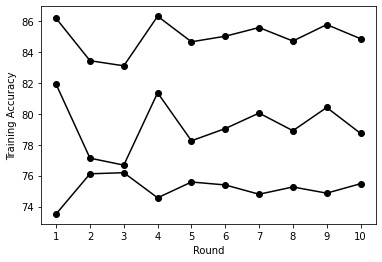

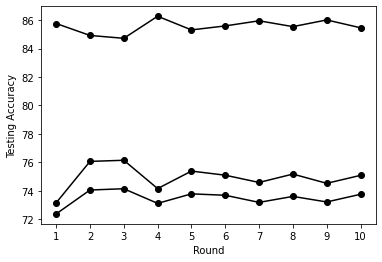

995/995 [==============================] - 1s 1ms/step
Validation 3 - Round m3 ts: 75.09, m4 ts: 73.76, e ts: 85.46
< Validation 4 >
Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.52, m4 tr: 75.52, e tr: 84.84
m3 ts: 81.42, m4 ts: 75.28, e ts: 85.93
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.84, m4 tr: 75.23, e tr: 85.13
m3 ts: 81.92, m4 ts: 74.98, e ts: 86.21
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.92, m4 tr: 76.09, e tr: 83.54
m3 ts: 80.07, m4 ts: 75.73, e ts: 86.28
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.79, m4 tr: 76.34, e tr: 82.5
m3 ts: 79.12, m4 ts: 76.04, e ts: 86.42
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.83, m4 tr: 76.4, e tr: 82.3
m3 ts: 79.21, m4 ts: 76.13, e ts: 86.35
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.87, m4 tr: 76.11, e tr: 83.51
m3 ts: 79.72, m4 ts: 75.74, e ts: 86.42
Round 7
995/

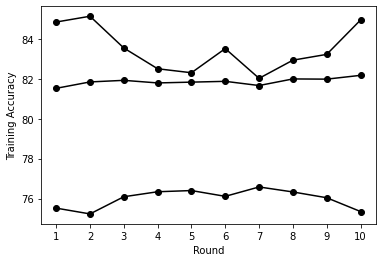

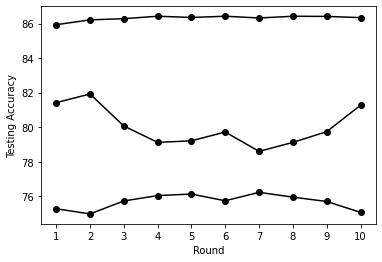

995/995 [==============================] - 2s 2ms/step
Validation 4 - Round m3 ts: 81.27, m4 ts: 75.07, e ts: 86.34
< Validation 5 >
Round 1
995/995 [==============================] - 1s 1ms/step
m3 tr: 74.78, m4 tr: 69.86, e tr: 82.71
m3 ts: 69.51, m4 ts: 70.09, e ts: 81.94
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.74, m4 tr: 73.69, e tr: 85.87
m3 ts: 74.53, m4 ts: 74.25, e ts: 85.96
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.76, m4 tr: 74.61, e tr: 84.26
m3 ts: 75.34, m4 ts: 75.14, e ts: 86.2
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.97, m4 tr: 74.43, e tr: 84.44
m3 ts: 75.3, m4 ts: 74.99, e ts: 86.18
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 77.53, m4 tr: 74.84, e tr: 82.9
m3 ts: 75.92, m4 ts: 75.45, e ts: 86.27
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 76.6, m4 tr: 75.1, e tr: 81.9
m3 ts: 76.15, m4 ts: 75.82, e ts: 86.29
Round 7
995/995

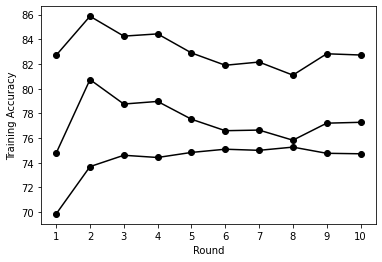

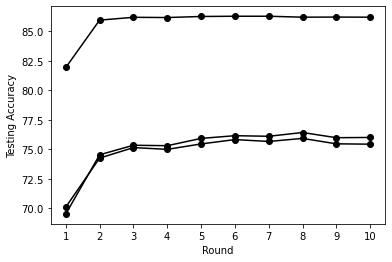

995/995 [==============================] - 2s 2ms/step
Validation 5 - Round m3 ts: 76.0, m4 ts: 75.43, e ts: 86.21


In [13]:
m3_acc_ls = []
m4_acc_ls = []
final_tr_acc_ls = []
final_ts_acc_ls = []
e_acc_little_data_ls = []
total_val_acc = []

for ri in range(1, validation_round+1):
    print('< Validation {} >'.format(ri))
    weighting_fac = 0.001
    
    m3tr = pd.read_csv(input_dir + "m3_tr_{}.csv".format(ri))
    m3ts = pd.read_csv(input_dir + "m3_ts_{}.csv".format(ri))   
    m4tr = pd.read_csv(input_dir + "m4_tr_{}.csv".format(ri))
    m4ts = pd.read_csv(input_dir + "m4_ts_{}.csv".format(ri))      
    etr = pd.read_csv(input_dir + "e_tr_{}.csv".format(ri))
    ets = pd.read_csv(input_dir + "e_ts_{}.csv".format(ri))  
    
    m3tr, m3ts, m4tr, m4ts, etr, ets = data_preprocessing(
        m3tr, m3ts, m4tr, m4ts, etr, ets)
    
    m3_factor, m4_factor, e_factor = non_iid_factors2(m3tr, m4tr, etr)
    noniid_ls = [m3_factor, m4_factor, e_factor]
    
    hos_tr_ls = [m3tr, m4tr, etr]
    hos_ts_ls = [m3ts, m4ts, ets]
    hos_tr_x_ls = []
    hos_tr_y_ls = []
    hos_ts_x_ls = []
    hos_ts_y_ls = []
    
    for hos_tr, hos_ts in zip(hos_tr_ls, hos_ts_ls):
        tr_x, tr_y = fun1.df_xy(hos_tr,5)
        ts_x, ts_y = fun1.df_xy(hos_ts,5)
        hos_tr_x_ls.append(tr_x)
        hos_tr_y_ls.append(tr_y)
        hos_ts_x_ls.append(ts_x)
        hos_ts_y_ls.append(ts_y)   
            
    cluster_weight_ls = get_weight_ls(hos_tr_y_ls)
    model_0 = create_keras_model(hos_tr_x_ls[0])
    merge_w = model_0.get_weights()
    r_tr_acc_ls = []
    r_ts_acc_ls = []

    for round_i in range(1, total_rounds+1):
        tr_acc_ls = []
        ts_acc_ls = []
        weighting_fac = weighting_fac * 0.9

        print('Round {}'.format(round_i))
        model_weight_ls = []

        for tr_x1, tr_y1, regu_para in zip(
            hos_tr_x_ls, hos_tr_y_ls, noniid_ls):
            
            m0 = create_and_compile_model(tr_x1, merge_w, 
                                          lr, regu_para*weighting_fac)
            m1 = model_train_round(m0, tr_x1, tr_y1, 
                                   epo_num, bs)
            m1_w = m1.get_weights()
            model_weight_ls.append(m1_w)
            
        merge_w = np.average(model_weight_ls, axis=0, 
                             weights=cluster_weight_ls)
        m2 = create_keras_model(hos_tr_x_ls[0])
        m2.set_weights(merge_w)    
        lr = lr*lr_decay_rate

        for tr_x, tr_y, ts_x, ts_y in zip(
            hos_tr_x_ls, hos_tr_y_ls, hos_ts_x_ls, hos_ts_y_ls):

            tr_acc = fun2.evaulate_acc(m2, tr_x, tr_y)
            ts_acc = fun2.evaulate_acc(m2, ts_x, ts_y)
            tr_acc_ls.append(tr_acc)
            ts_acc_ls.append(ts_acc)

        print('m3 tr: {}, m4 tr: {}, e tr: {}'.format(
            tr_acc_ls[0], tr_acc_ls[1], tr_acc_ls[2]))
        print('m3 ts: {}, m4 ts: {}, e ts: {}'.format(
            ts_acc_ls[0], ts_acc_ls[1], ts_acc_ls[2]))
        
        r_tr_acc_ls.append(tr_acc_ls)
        r_ts_acc_ls.append(ts_acc_ls)   

    avg_tr = np.mean(r_tr_acc_ls)
    avg_ts = np.mean(r_ts_acc_ls)
    print('tr acc:', avg_tr)
    print('ts acc:', avg_ts)

    plot_performance_curve(r_tr_acc_ls, total_rounds, 'Training')
    plot_performance_curve(r_ts_acc_ls, total_rounds, 'Testing')
    
    val_ts_ls = []
    for ts_x, ts_y in zip(hos_ts_x_ls, hos_ts_y_ls):
        ts_acc = fun2.evaulate_acc(m2, ts_x, ts_y)
        val_ts_ls.append(ts_acc)
        
    print('Validation {} - Round m3 ts: {}, m4 ts: {}, e ts: {}'.format(
        ri, val_ts_ls[0], val_ts_ls[1], val_ts_ls[2]))    
    total_val_acc.append(val_ts_ls)

In [14]:
total_val_acc

[[80.69, 75.04, 85.99],
 [81.53, 72.04, 86.42],
 [75.09, 73.76, 85.46],
 [81.27, 75.07, 86.34],
 [76.0, 75.43, 86.21]]

In [15]:
import statistics

acc_ls = []
total_val_acc_t = np.array(total_val_acc).T.tolist()
for each_acc in total_val_acc_t:
    m_acc = statistics.mean(each_acc)
    print(m_acc)
    acc_ls.append(m_acc)
print('mean: ',statistics.mean(acc_ls))

78.916
74.268
86.084
mean:  79.756
